In [32]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
sys.path.append('../')

In [34]:
MC_params = {'nh' : 3e2, 'T': 20., 'Chi': 1e-2, 'xh': 0., 'xC': 1e-4, 'y' : 0.99,  'gamma': 0, 'dipole': 9.3, 'line':7}  

In [ ]:
import functools

import SpyDust.Grain as Grain
from SpyDust.SpyDust import SpyDust_given_grain_size_shape
from SpyDust.util import makelogtab

a_min=3.5e-8
a_max=3.5e-7
a2=6.0e-8
# a2=a_max

Num_a = 80
Num_beta = 80

a_tab = makelogtab(a_min, a_max, Num_a)
beta_tab  = np.linspace(-0.47, 0.5, Num_beta)


# beta_tab_disk = np.linspace(-0.48, -0.2, Num_beta)
# beta_tab_ellip = np.linspace(-0.2, 0.2, Num_beta)

def cache_last_call(func):
    last_args = {"args": None, "kwargs": None, "result": None}

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        # Compare with last args
        if (last_args["args"] is not None 
            and len(args) == len(last_args["args"]) 
            and all(np.array_equal(a, b) if isinstance(a, np.ndarray) else a == b
                    for a, b in zip(args, last_args["args"])) 
            and kwargs == last_args["kwargs"]):
            return last_args["result"]

        # Otherwise, compute new
        result = func(*args, **kwargs)
        last_args["args"] = args
        last_args["kwargs"] = kwargs
        last_args["result"] = result
        return result

    return wrapper

@cache_last_call
def generate_same_grains_SED(env, a, beta, a2):
    # if "a" is a number, return a single SED result; if "a" is a table, return a table of SED results
    if isinstance(a, (int, float)):
        result = SpyDust_given_grain_size_shape(env, a, beta, 
                                                min_freq=0.1, max_freq=100.0, n_freq=200,
                                                N_angular_Omega=500,
                                                a2=a2
                                                )
        result_SED = result[1]
    else:
        result_SED = []
        for a_val in a:
            result = SpyDust_given_grain_size_shape(env, a_val, beta, 
                                                min_freq=0.1, max_freq=100.0, n_freq=200,
                                                N_angular_Omega=500,
                                                a2=a2)
            result_SED.append(result[1])
        result_SED = np.array(result_SED)

    freqs = result[0]
    return freqs, result_SED

def SED_list_given_SSE(a_beta_tab, env, a2):   
    # generate the SED list given the tables of grain size (S) a_tab, grain shape (S) beta_tab, and the environment (E)
    SED_list = []
    from tqdm import tqdm
    for a, beta in tqdm(a_beta_tab):
        freqs, result = generate_same_grains_SED(env, a, beta, a2=a2)
        SED_list.append(result)
    return freqs,np.array(SED_list)

In [36]:
env = MC_params
a_beta_tab = np.array(np.meshgrid(a_tab, beta_tab)).T.reshape(-1, 2)

freqs, MC_SEDs_a_beta =  SED_list_given_SSE(a_beta_tab, env, a2=a2) # tumbling grains


100%|██████████| 6400/6400 [14:39<00:00,  7.27it/s]


In [37]:
from SpyDust.SED_fit import fit_sed_ensemble

In [2]:
from SpyDust.util import makelogtab

makelogtab(-5, -2, 10)

array([-4.77609552, -4.35791749, -3.97635364, -3.62819818, -3.31052598,
       -3.02066803, -2.75618902, -2.51486686, -2.29467401, -2.09376047])

In [ ]:
MC_features_a_beta =  fit_sed_ensemble(freqs, MC_SEDs_a_beta, thres=1e-3)

100%|██████████| 6400/6400 [00:00<00:00, 6919.75it/s]


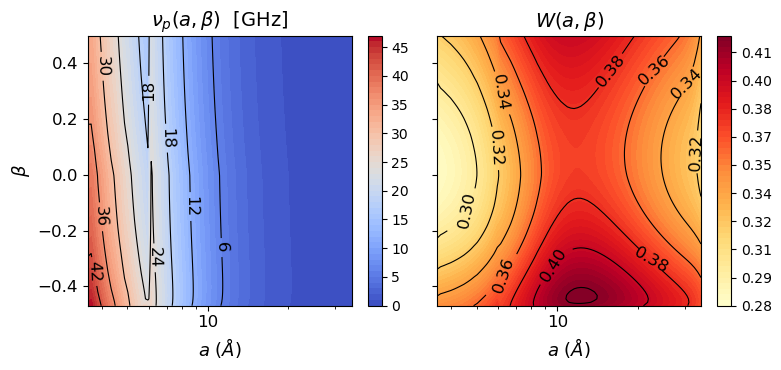

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, NullFormatter


features = MC_features_a_beta


X = a_beta_tab.reshape(Num_a,Num_beta,2)[:, :, 0]*1e8
Y = a_beta_tab.reshape(Num_a,Num_beta,2)[:, :, 1]
Z1 = np.exp(features.reshape(Num_a,Num_beta,2)[:, :, 0])
Z2 = features.reshape(Num_a,Num_beta,2)[:, :, 1]

# -------------------------
# Create the plot
# -------------------------
fig, ax = plt.subplots(1, 2, figsize=(8, 3.8), sharey=True)
ax = ax.flatten()

# Filled heatmap (smooth color shading)
# cmap = plt.cm.viridis
cmap = plt.cm.coolwarm
heat = ax[0].contourf(X, Y, Z1, levels=50, cmap=cmap)

# Contour lines (iso-values)
contours = ax[0].contour(X, Y, Z1, levels=8, colors='black', linewidths=0.8)
ax[0].clabel(contours, inline=True, fontsize=12, fmt="%.0f")

# Colorbar
cbar = fig.colorbar(heat, ax=ax[0])
# cbar.set_label("Function value", fontsize=12)
ax[0].set_xscale('log')

# Axis labels and style
ax[0].set_xlabel(r"$a$ ($\AA$)", fontsize=13)
ax[0].set_ylabel(r"$\beta$", fontsize=13)
ax[0].set_title(fr"$\nu_p(a, \beta)$  [GHz]", fontsize=14)
ax[0].tick_params(labelsize=12)

cmap = plt.cm.YlOrRd
heat = ax[1].contourf(X, Y, Z2, levels=50, cmap=cmap)
contours = ax[1].contour(X, Y, Z2, levels=8, colors='black', linewidths=0.8)
# ax[1].clabel(contours, inline=True, fontsize=10, fmt="%.2f",
#             rightside_up=True, inline_spacing=15)

ax[1].margins(0.05)  # Small margin
levels_to_label = contours.levels[1:-1] if len(contours.levels) > 2 else contours.levels
ax[1].clabel(contours, levels=levels_to_label, inline=True, fontsize=12, fmt="%.2f",
             rightside_up=True)

ax[1].set_xscale('log')

cbar = fig.colorbar(heat, ax=ax[1], format="%.2f")
ax[1].set_xlabel(r"$a$ ($\AA$)", fontsize=13)
# ax[1].set_ylabel(r"$\beta$", fontsize=13)
ax[1].set_title(fr"$W(a, \beta)$", fontsize=14)
ax[1].tick_params(labelsize=12)

formatter = FuncFormatter(lambda value, _: f"{value:g}")
for axis in ax:
    axis.xaxis.set_major_formatter(formatter)
    axis.xaxis.set_minor_formatter(NullFormatter())

fig.tight_layout()

plt.savefig("MC_feature_map_varying_size_shape.pdf", dpi=300)
plt.show()

[ 3.65441651e-08 -2.24430380e-01]


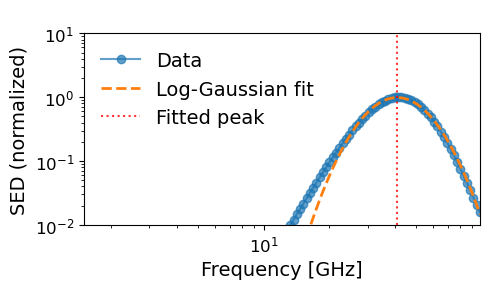

{'f_peak': np.float64(41.020073966409846),
 'sigma': np.float64(0.3013215988404537),
 'fwhm': np.float64(29.720570906833867),
 'r_squared': np.float64(0.9966409399660844),
 'amplitude': np.float64(2.0757279599934097e-10),
 'f_peak_error': np.float64(0.09223954457280996),
 'sigma_error': np.float64(0.002251118182205364),
 'n_points_used': 58,
 'threshold_value': np.float64(2.1043813474011984e-12)}

In [ ]:
import importlib
import SpyDust.SED_fit
importlib.reload(SpyDust.SED_fit)
from SpyDust.SED_fit import measure_sed_peak_properties

ind=100
print(a_beta_tab[ind])
measure_sed_peak_properties(freqs, MC_SEDs_a_beta[ind], plot=True, save_path="SED_fit_example.pdf", thres=1e-2, title=' ')


# Emulator

In [81]:
import MomentEmu
# Reload the module to reflect recent changes
import importlib
importlib.reload(MomentEmu)
from MomentEmu import PolyEmu


In [ ]:
def generate_random_a_beta_tab(n_samples, a_min=a_min, a_max=a_max, beta_min=-0.48, beta_max=0.2):
    a_random = np.random.uniform(low=a_min, high=a_max, size=n_samples)
    beta_random = np.random.uniform(low=beta_min, high=beta_max, size=n_samples)
    return np.array(list(zip(a_random, beta_random)))

test_a_beta_tab_disk = generate_random_a_beta_tab(1000, a_min=a_min, a_max=a_max, beta_min=-0.48, beta_max=-0.2)
test_a_beta_tab_ellip = generate_random_a_beta_tab(1000, a_min=a_min, a_max=a_max, beta_min=-0.2, beta_max=0.2)

freqs, test_MC_SEDs_ellip =  SED_list_given_SSE(test_a_beta_tab_ellip, MC_params, a2=a_min*0.9)
freqs, test_MC_SEDs_disk =  SED_list_given_SSE(test_a_beta_tab_disk, MC_params, a2=a_max*1.1)

test_MC_features_ellip = fit_sed_ensemble(freqs, test_MC_SEDs_ellip, thres=1e-3)
test_MC_features_disk = fit_sed_ensemble(freqs, test_MC_SEDs_disk, thres=1e-3)

100%|██████████| 1000/1000 [00:00<00:00, 7085.02it/s]


In [14]:
# Create emulator with both forward and inverse capabilities
MC_feature_disk_single = PolyEmu(
    a_beta_tab_disk,      # Input parameter samples (grain size and shape)
    MC_features_disk, 
    X_test=test_a_beta_tab_disk,
    Y_test=test_MC_features_disk,
    forward=True,              # Enable forward emulation: parameters → observables
    max_degree_forward=25,     # Max polynomial degree for forward mapping (lower for high-dimensional problems)
    RMSE_lower=0.01,
    fRMSE_tol=1e-1,
    return_max_frac_err=True
)

Generating forward emulator...
Candidate models within 10.0% of min RMSE : [ 9 10]
RMSE of candidate models : [0.01135576 0.01049325]
Selected best model index based on BIC : 10
Forward emulator generated with degree 13, RMSE_val of 0.010493248208242382.
Performing dimension reduction...
Dimension reduced  from 105 modes to 102 modes.
After the dimension reduction, the RMSE: 0.01049453761312055, AIC: -8909.800769011388, BIC: -57434.391488199406
Forward emulator maximum fractional error: 0.2970842764187609. (If the true value is close to 0, this value could be extremely large. This is fine.)


In [15]:
# Create emulator with both forward and inverse capabilities
MC_feature_ellip_single = PolyEmu(
    a_beta_tab_ellip,      # Input parameter samples (grain size and shape)
    MC_features_ellip, 
    X_test=test_a_beta_tab_ellip,
    Y_test=test_MC_features_ellip,
    forward=True,              # Enable forward emulation: parameters → observables
    max_degree_forward=25,     # Max polynomial degree for forward mapping (lower for high-dimensional problems)
    RMSE_lower=0.01,
    fRMSE_tol=1e-1,
    return_max_frac_err=True
)

Generating forward emulator...
Forward emulator generated with degree 16, RMSE_val of 0.009096839827320034.
Performing dimension reduction...
Dimension reduced  from 153 modes to 152 modes.
After the dimension reduction, the RMSE: 0.0090970562726422, AIC: -9095.608808630437, BIC: -58825.36027829394
Forward emulator maximum fractional error: 0.7121070357570146. (If the true value is close to 0, this value could be extremely large. This is fine.)


## Distribution of grain size

In [70]:
import SpyDust.Grain as Grain


def eval_beta_arbitrary(a, d):
    if a <= a2:
        beta_val = Grain.cylindrical_params(a, d)[1]
    else:
        beta_val=0.
    return beta_val

def _normalise(w):
    """Turn any non-negative weight array into a PDF."""
    w = np.asarray(w, dtype=float)
    if np.any(w < 0):                       # sanity check
        raise ValueError("Weights must be non-negative.")
    s = w.sum()
    if s == 0:
        raise ValueError("All weights are zero → cannot normalise.")
    return w / s

# a_list = np.concatenate((a_tab_disk, a_tab_ellip))
a_list = a_tab

def grain_size_dist(gamma, log_a0, sigma):
    """
    dn/da propto exp[(gamma - 1) lna - 1/2 ((ln(a) - ln(a0) + sigma**2/2)^2 / sigma^2)]
    equivalent to
    dn/dlna propto exp[gamma * lna - 1/2 ((ln(a) - ln(a0) + sigma**2/2)^2 / sigma^2)]
    """
    ln_a_list = np.log(a_list)
    exponent = gamma  * ln_a_list - 0.5 * ( (ln_a_list - log_a0 + sigma**2/2) / sigma ) ** 2
    max_exponent = np.max(exponent)
    exponent -= max_exponent
    weights = np.exp(exponent)
    dln_a_1 =  ln_a_list[1] - ln_a_list[0]
    dln_a_2 =  ln_a_list[-1] - ln_a_list[-2]
    assert np.isclose(dln_a_1, dln_a_2), "a_list not evenly spaced in log-space"
    return _normalise(weights)

def grain_shape_dist(a, d, delta):
    beta_tab = beta_tab_disk
    ln_beta_t_tab = np.log( beta_tab + 0.5 )
    ln_beta_d_t = np.log( eval_beta_arbitrary(a, d) + 0.5 )
    exponent = - ln_beta_t_tab - 0.5 * ( (ln_beta_t_tab  - ln_beta_d_t + delta**2/2 ) / delta ) ** 2
    max_exponent = np.max(exponent)
    exponent -= max_exponent
    weights = np.exp(exponent)
    return _normalise(weights)

aux = np.where(a_tab <= a2)
Num_a_disk = aux[0].size
a_tab_disk = a_tab[:Num_a_disk]
a_tab_ellip = a_tab[Num_a_disk:]

def generate_size_shape_dist(gamma, log_a0, sigma, d, delta):
    distr_a_beta_disk = np.zeros((Num_a_disk, Num_beta))

    distr_a = grain_size_dist(gamma, log_a0, sigma)
    distr_a_disk = distr_a[:Num_a_disk]
    distr_a_ellip = distr_a[Num_a_disk:]

    for i in range(Num_a_disk):
        a = a_tab[i]
        distr_a_beta_disk[i, :] = grain_shape_dist(a, d, delta) * distr_a_disk[i]

    return distr_a_beta_disk, distr_a_ellip
    

In [17]:
# Generate SEDs for larger, spherical grains (beta=0)

a_beta_tab_sphe = []
for a in a_tab_ellip:
    a_beta_tab_sphe.append([a, 0.])
a_beta_tab_sphe = np.array(a_beta_tab_sphe)

freqs, MC_SEDs_sphe =  SED_list_given_SSE(a_beta_tab_sphe, MC_params, a2=a2)

# Generate SEDs for smaller, disk-like grains
a_beta_tab_small = np.array(np.meshgrid(a_tab_disk, beta_tab)).T.reshape(-1, 2)
freqs, MC_SEDs_small =  SED_list_given_SSE(a_beta_tab_small, MC_params, a2=a2)


100%|██████████| 1520/1520 [03:59<00:00,  6.35it/s]


In [71]:
def synthesize_SED(gamma, log_a0, sigma, d, delta):
    distr_a_beta_disk, distr_a_ellip = generate_size_shape_dist(gamma, log_a0, sigma, d, delta)
    SED_disk = np.sum(distr_a_beta_disk[:, :, np.newaxis] * MC_SEDs_small.reshape(Num_a_disk,Num_beta,-1), 
                        axis=(0, 1))
    SED_ellip = np.sum(distr_a_ellip[:, np.newaxis] * MC_SEDs_sphe, axis=0)
    return SED_disk + SED_ellip

In [51]:
# reference values of the parameters:
gamma_ref, log_a0_ref, sigma_ref, d_ref, delta_ref = 0., np.log(a2), 0.5, Grain.d, 0.01


In [ ]:
# from SpyDust.SED_fit import measure_sed_peak_properties
# Reload the module and SED fitting function
import importlib
import SpyDust
importlib.reload(SpyDust.SED_fit)



In [54]:
gamma_list = np.linspace(-2.5, 2, 100)
log_a0_list = np.linspace(np.log(a_min), np.log(a_max), 100)
sigma_list = makelogtab(0.01, 10, 100)
d_list = np.linspace(Grain.d/2, Grain.d*2, 100)
delta_list = makelogtab(0.001, 1, 100)

In [72]:

SED_gamma_list = []
for gamma in gamma_list:
    SED_gamma_list.append(synthesize_SED(gamma, log_a0_ref, sigma_ref, d_ref, delta_ref))
SED_gamma_list = np.array(SED_gamma_list)

SED_log_a0_list = []
for log_a0 in log_a0_list:
    SED_log_a0_list.append(synthesize_SED(gamma_ref, log_a0, sigma_ref, d_ref, delta_ref))
SED_log_a0_list = np.array(SED_log_a0_list)

SED_sigma_list = []
for sigma in sigma_list:
    SED_sigma_list.append(synthesize_SED(gamma_ref, log_a0_ref, sigma, d_ref, delta_ref))
SED_sigma_list = np.array(SED_sigma_list)

SED_d_list = []
for d in d_list:
    SED_d_list.append(synthesize_SED(gamma_ref, log_a0_ref, sigma_ref, d, delta_ref))
SED_d_list = np.array(SED_d_list)

SED_delta_list = []
for delta in delta_list:
    SED_delta_list.append(synthesize_SED(gamma_ref, log_a0_ref, sigma_ref, d_ref, delta))
SED_delta_list = np.array(SED_delta_list)


In [ ]:
SED_gamma_features = fit_sed_ensemble(freqs, SED_gamma_list, thres=1e-3)

SED_log_a0_features = fit_sed_ensemble(freqs, SED_log_a0_list, thres=1e-3)

SED_sigma_features = fit_sed_ensemble(freqs, SED_sigma_list, thres=1e-3)

SED_d_features = fit_sed_ensemble(freqs, SED_d_list, thres=1e-3)

SED_delta_features = fit_sed_ensemble(freqs, SED_delta_list, thres=1e-3)

100%|██████████| 100/100 [00:00<00:00, 5679.49it/s]


In [ ]:
SED_ref = synthesize_SED(gamma_ref, log_a0_ref, sigma_ref, d_ref, delta_ref)

SED_ref_features = fit_sed_ensemble(freqs, SED_ref, thres=1e-3)

100%|██████████| 1/1 [00:00<00:00, 1649.35it/s]


In [62]:
SED_ref_features

array([3.42526718, 0.48445645])

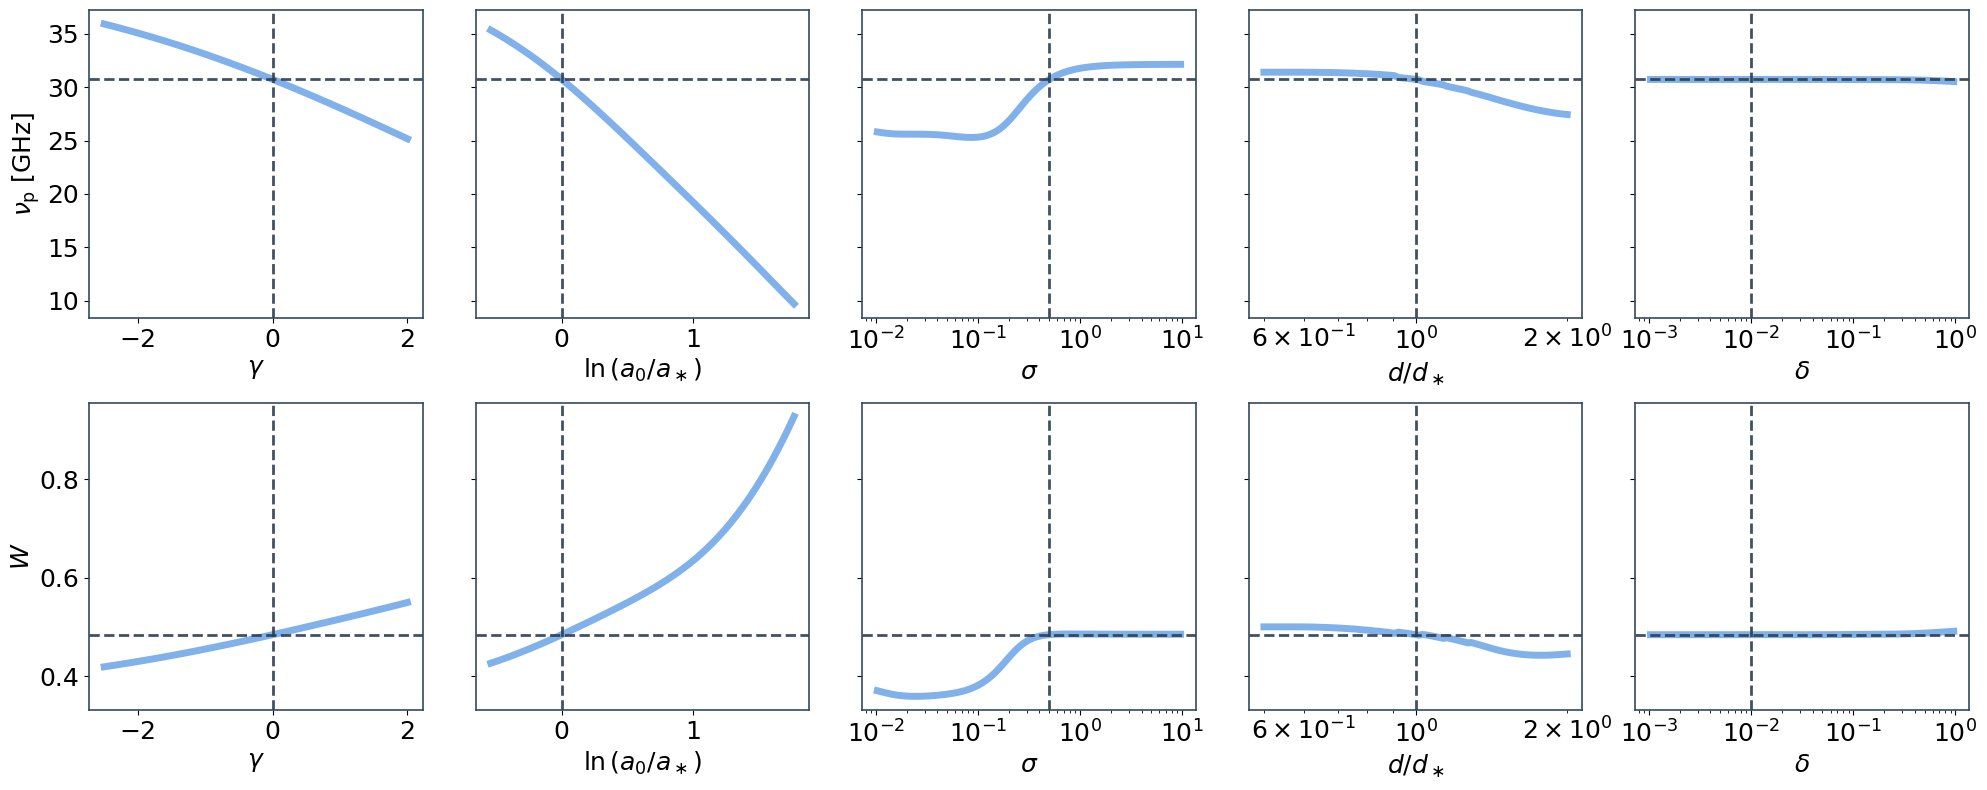

In [63]:
import matplotlib.pyplot as plt

# Create figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey='row')

# Define improved styling
curve_color = '#4A90E2'  # Light blue
curve_alpha = 0.7
curve_linewidth = 5
ref_color = '#2C3E50'  # Dark blue-gray
ref_linewidth = 2
ref_alpha = 0.9

# First row - nu_p [GHz] (exponential of first feature)
axes[0, 0].plot(gamma_list, np.exp(SED_gamma_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 0].set_xlabel(r'$\gamma$')
# show the reference value
axes[0, 0].axvline(gamma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 0].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 1].plot(log_a0_list - np.log(a2), np.exp(SED_log_a0_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 1].set_xlabel(r'$\ln{{(a_0 / a_\ast)}}$')
# show the reference value
axes[0, 1].axvline(log_a0_ref - np.log(a2), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 1].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 2].plot(sigma_list, np.exp(SED_sigma_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 2].set_xscale('log')
axes[0, 2].set_xlabel(r'$\sigma$')
# show the reference value
axes[0, 2].axvline(sigma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 2].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 3].plot(d_list/d_ref, np.exp(SED_d_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 3].set_xlabel(r'$d/d_\ast$')
axes[0, 3].set_xscale('log')
# show the reference value
axes[0, 3].axvline(1., color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 3].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 4].plot(delta_list, np.exp(SED_delta_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 4].set_xscale('log')
axes[0, 4].set_xlabel(r'$\delta$')
# show the reference value
axes[0, 4].axvline(delta_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 4].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

# Set shared y-label for first row
axes[0, 0].set_ylabel(r'$\nu_{\rm p}$ [GHz]')

# Second row - beta (second feature)
axes[1, 0].plot(gamma_list, SED_gamma_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 0].set_xlabel(r'$\gamma$')
axes[1, 0].axvline(gamma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 0].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 1].plot(log_a0_list - np.log(a2), SED_log_a0_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 1].set_xlabel(r'$\ln{{(a_0 / a_\ast)}}$')
# show the reference value
axes[1, 1].axvline(log_a0_ref - np.log(a2), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 1].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 2].plot(sigma_list, SED_sigma_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 2].set_xscale('log')
axes[1, 2].set_xlabel(r'$\sigma$')
# show the reference value
axes[1, 2].axvline(sigma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 2].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 3].plot(d_list / d_ref, SED_d_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 3].set_xlabel(r'$d/d_\ast$')
axes[1, 3].set_xscale('log')
# show the reference value
axes[1, 3].axvline(1., color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 3].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 4].plot(delta_list, SED_delta_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 4].set_xscale('log')
axes[1, 4].set_xlabel(r'$\delta$')
# show the reference value
axes[1, 4].axvline(delta_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 4].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

# Set shared y-label for second row
axes[1, 0].set_ylabel(r'$W$')

# Enhanced styling
font_size = 18
for ax in axes.flat:
    ax.tick_params(axis='both', which='both', labelsize=font_size)
    ax.set_title(ax.get_title(), fontsize=font_size)
    ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
    ax.set_ylabel(ax.get_ylabel(), fontsize=font_size)
    # Add subtle grid for better readability
    # ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    # Improve spine appearance
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('#34495E')

# Adjust layout and show
plt.tight_layout()
plt.savefig("SED_feature_given_distribution.pdf", dpi=300, bbox_inches='tight')
plt.show()

## MC Emulation ...

In [ ]:
# Sample the distribution parameter space - drawn randomly for each parameter with a uniform distribution; not sampling d and delta for now
N_samples = 10000
gamma_list = np.random.uniform(-2.5, 2, N_samples)
log_a0_list = np.random.uniform(np.log(a_min), np.log(a_max), N_samples)
sigma_list = np.random.uniform(0.01, 10, N_samples)
param_array_training = np.column_stack((gamma_list, log_a0_list, sigma_list)) # Generate the parameter array (N_samples, 3)


SED_array_training = []
import tqdm
for i in tqdm.tqdm(range(N_samples)):
    SED_array_training.append(synthesize_SED(gamma_list[i], log_a0_list[i], sigma_list[i], d_ref, delta_ref))
SED_array_training = np.array(SED_array_training)
features_training = fit_sed_ensemble(freqs, SED_array_training, thres=1e-3)


# Generate the test parameter array (N_samples, 3)
N_samples_test = 2000
gamma_list_test = np.random.uniform(-2.5, 2, N_samples_test)
log_a0_list_test = np.random.uniform(np.log(a_min), np.log(a_max), N_samples_test)
sigma_list_test = np.random.uniform(0.01, 10, N_samples_test)
param_array_test = np.column_stack((gamma_list_test, log_a0_list_test, sigma_list_test))

SED_array_test = []
for i in tqdm.tqdm(range(N_samples_test)):
    SED_array_test.append(synthesize_SED(gamma_list_test[i], log_a0_list_test[i], sigma_list_test[i], d_ref, delta_ref))
SED_array_test = np.array(SED_array_test)
features_test = fit_sed_ensemble(freqs, SED_array_test, thres=1e-3)

100%|██████████| 2000/2000 [00:00<00:00, 5732.98it/s]


In [75]:
def calculate_moments(a_dist_weights):
    mean = np.sum(a_dist_weights * a_list)
    variance = np.sum(a_dist_weights * (a_list - mean)**2)
    skewness = np.sum(a_dist_weights * (a_list - mean)**3) / (variance ** 1.5)
    kurtosis = np.sum(a_dist_weights * (a_list - mean)**4) / (variance ** 2)
    fifth_moment = np.sum(a_dist_weights * (a_list - mean)**5) / (variance ** 2.5)
    sixth_moment = np.sum(a_dist_weights * (a_list - mean)**6) / (variance ** 3)
    return [mean, variance, skewness, kurtosis, fifth_moment, sixth_moment]

# Calculate the a-distributions
a_dist_weights_training = []
for i in tqdm.tqdm(range(N_samples)):
    a_dist_weights = grain_size_dist(gamma_list[i], log_a0_list[i], sigma_list[i]) # These are statistical weights for each grain size in a_tab
    a_dist_weights_training.append(a_dist_weights) 
a_dist_weights_training = np.array(a_dist_weights_training)

# For each distribution of a, calculate the moments: mean, variance, skewness, kurtosis, ..., up to 6th order    
a_moments_training = []
for i in tqdm.tqdm(range(N_samples)):
    a_moments = calculate_moments(a_dist_weights_training[i])
    a_moments_training.append(a_moments)
a_moments_training = np.array(a_moments_training)

# Calculate the a-distributions for test set
a_dist_weights_test = []
for i in tqdm.tqdm(range(N_samples_test)):
    a_dist_weights = grain_size_dist(gamma_list_test[i], log_a0_list_test[i], sigma_list_test[i]) # These are statistical weights for each grain size in a_tab
    a_dist_weights_test.append(a_dist_weights) 
a_dist_weights_test = np.array(a_dist_weights_test)

# For each distribution of a, calculate the moments: mean, variance, skewness, kurtosis, ..., up to 6th order    
a_moments_test = []
for i in tqdm.tqdm(range(N_samples_test)):
    a_moments = calculate_moments(a_dist_weights_test[i])
    a_moments_test.append(a_moments)
a_moments_test = np.array(a_moments_test)

100%|██████████| 2000/2000 [00:00<00:00, 62231.41it/s]


In [143]:
# MC_parameters2feature = MomentEmu.PolyEmu(
#     param_array_training,      # Input parameter samples (grain size and shape)
#     features_training, 
#     X_test=param_array_test,
#     Y_test=features_test,
#     forward=True,              # Enable forward emulation: parameters → observables
#     max_degree_forward=25,     # Max polynomial degree for forward mapping (lower for high-dimensional problems)
#     backward=True,
#     max_degree_backward=25,    # Max polynomial degree for inverse mapping (observables → parameters)
#     RMSE_lower=0.01,
#     fRMSE_tol=1e-1,
#     return_max_frac_err=True
# )

In [106]:
# transform the a-distribution moments so that even orders are logarithmic
a_moments_training_transformed = copy.deepcopy(a_moments_training)
# Change unit (from cm) to angstroms for better numerical stability
a_moments_training_transformed[:, 0] *= 1e8   # mean
a_moments_training_transformed[:, 1] *= 1e16  # variance
a_moments_training_transformed[:, 2] *= 1e24  # skewness
a_moments_training_transformed[:, 3] *= 1e32  # kurtosis
a_moments_training_transformed[:, 4] *= 1e40  # fifth moment
a_moments_training_transformed[:, 5] *= 1e48  # sixth moment

# a_moments_training_transformed[:, 0] = np.log(a_moments_training[:, 0])   # log(mean)
# a_moments_training_transformed[:, 1] = np.log(a_moments_training[:, 1])   # log(variance)
# a_moments_training_transformed[:, 3] = np.log(a_moments_training[:, 3])   # log(kurtosis)
# a_moments_training_transformed[:, 5] = np.log(a_moments_training[:, 5])   # log(sixth moment)

a_moments_test_transformed = copy.deepcopy(a_moments_test)
a_moments_test_transformed[:, 0] *= 1e8   # mean
a_moments_test_transformed[:, 1] *= 1e16  # variance
a_moments_test_transformed[:, 2] *= 1e24  # skew
a_moments_test_transformed[:, 3] *= 1e32  # kurtosis
a_moments_test_transformed[:, 4] *= 1e40  # fifth moment
a_moments_test_transformed[:, 5] *= 1e48  # sixth moment

# a_moments_test_transformed[:, 0] = np.log(a_moments_test[:, 0])   # log(mean)
# a_moments_test_transformed[:, 1] = np.log(a_moments_test[:, 1])   # log(variance)
# a_moments_test_transformed[:, 3] = np.log(a_moments_test[:, 3])   # log(kurtosis)
# a_moments_test_transformed[:, 5] = np.log(a_moments_test[:, 5])   # log(sixth moment)

# Create emulator with both forward and inverse capabilities
# for N_moments in range(2, 6):
N_moments = 2
MC_moment2feature = PolyEmu(
    a_moments_training_transformed[:, :N_moments],      # Input parameter samples (grain size and shape)
    features_training, 
    X_test=a_moments_test_transformed[:, :N_moments],
    Y_test=features_test,
    forward=True,              # Enable forward emulation: parameters → observables
    max_degree_forward=25,     # Max polynomial degree for forward mapping (lower for high-dimensional problems)
    backward=True,
    max_degree_backward=25,    # Max polynomial degree for inverse mapping (observables → parameters)
    RMSE_lower=0.01,
    fRMSE_tol=1e-1,
    return_max_frac_err=True
)

Generating forward emulator...
Candidate models within 10.0% of min RMSE : [10 13]
RMSE of candidate models : [0.01263308 0.01349581]
Selected best model index based on BIC : 10
Forward emulator generated with degree 13, RMSE_val of 0.012633075503730856.
Performing dimension reduction...
Dimension reduced  from 105 modes to 105 modes.


After the dimension reduction, the RMSE: 0.012633075503730856, AIC: -17275.747457783134, BIC: -86461.65154985817
Forward emulator maximum fractional error: 0.07089008598957366. (If the true value is close to 0, this value could be extremely large. This is fine.)
Generating backward emulator...
Candidate models within 10.0% of min RMSE : [7 8]
RMSE of candidate models : [0.09841238 0.09138513]
Selected best model index based on BIC : 8
Backward emulator generated with degree 11, RMSE_val of 0.09138512701196055.
Performing dimension reduction...
Dimension reduced  from 78 modes to 78  modes.
After the dimension reduction, the RMSE: 0.09138512701196055, AIC: -9414.690151684103, BIC: -47135.04420940637
Backward emulator maximum fractional error: 5995.922824249483. (If the true value is close to 0, this value could be extremely large. This is fine.)


In [147]:
MC_catalogue = [[21.3, 0.53], 
                [24.3, 0.78],
                [18.9, 0.46],
                [15.3, 0.59],
                [17.5, 0.57],
                [17.8, 0.47],
                [32.6, 0.65],
                [23.4, 0.51],
                [20.3, 0.60],
                [25.4, 0.72],
                [18.8, 0.58],
                [19.4, 0.68],
                [19.6, 0.89],
                [24.8, 0.48],
                [21.3, 0.62],
                [23.0, 0.50],
                [18.4, 0.58],
                [20.3, 0.57],
                [28.9, 0.53],
                [28.2, 0.53]]

DC_catalogue = [[25.7, 0.59], 
                [18.3, 0.58],
                [16.5, 0.70],
                [21.8, 0.57],
                [18.2, 0.64],
                [18.7, 0.66],
                [21.7, 0.68],
                [22.7, 0.66],
                [23.3, 0.54],
                [21.7, 0.57],
                [26.2, 0.54],
                [20.2, 0.59],
                [14.7, 0.52],
                [16.4, 0.68],
                [24.4, 0.49],
                [26.7, 0.64],
                [16.3, 0.52],
                [18.4, 0.64],
                [20.8, 0.64],
                [23.4, 0.41],
                [19.6, 0.89],
                [18.3, 0.43],
                [19.1, 0.53],
                [20.1, 0.59],
                [19.8, 0.64],
                [22.4, 0.47],
                [20.9, 0.57],
                [26.6, 0.59],
                [19.1, 0.51],
                [18.1, 0.54],
                [27.1, 0.96],
                [25.2, 0.58],
                [23.5, 0.49],
                [23.7, 0.45],
                [25.1, 0.65],
                [19.4, 0.52],
                [20.7, 0.69],
                [17.8, 0.47],
                [20.3, 0.68],
                [24.2, 0.49]
                ]

DC_catalogue = np.array(DC_catalogue)

MC_catalogue = np.array(MC_catalogue)

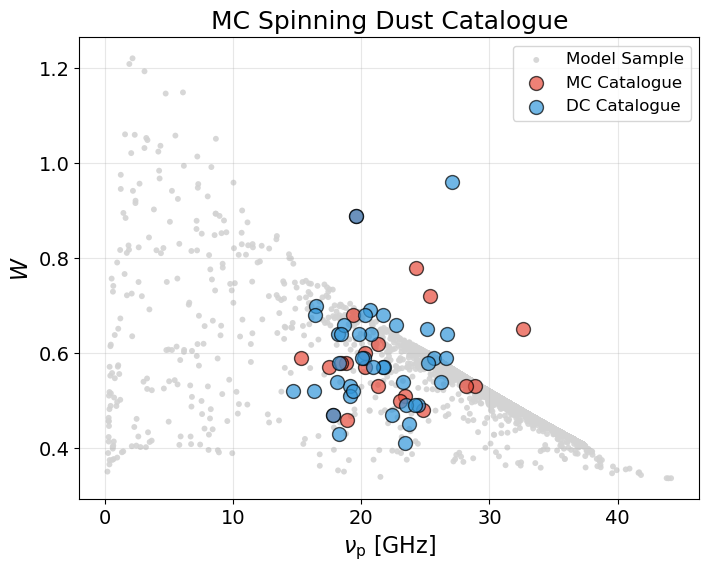

In [148]:
# Make the scatter plot
plt.figure(figsize=(8, 6))

# First, plot the training set features as light background
plt.scatter(np.exp(features_training[:, 0]), features_training[:, 1], 
           color='lightgray', s=18, alpha=0.9, edgecolors='none', 
           label='Model Sample', zorder=1)

# Then plot the MC catalogue on top
plt.scatter(MC_catalogue[:, 0], MC_catalogue[:, 1], 
           color='#E74C3C', s=100, alpha=0.7, edgecolors='k',
           label='MC Catalogue', zorder=2)

# Finally, plot the DC catalogue
plt.scatter(DC_catalogue[:, 0], DC_catalogue[:, 1], 
           color='#3498DB', s=100, alpha=0.7, edgecolors='k',
           label='DC Catalogue', zorder=3)

plt.xlabel(r'$\nu_{\rm p}$ [GHz]', fontsize=16)
plt.ylabel(r'$W$', fontsize=16)
plt.title('MC Spinning Dust Catalogue', fontsize=18)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='both', which='both', labelsize=14)

# Add legend
plt.legend(loc='upper right', fontsize=12, framealpha=0.8)

plt.savefig("MC_spinning_dust_catalogue.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [113]:
# Take the natural logarithm of the first column (nu_p)

import copy
MC_catalogue_transformed = copy.deepcopy(MC_catalogue)
MC_catalogue_transformed[:, 0] = np.log(MC_catalogue_transformed[:, 0])

MC_catelogue_a_moments = MC_moment2feature.backward_emulator(MC_catalogue_transformed)

In [102]:
a_moments_mean = np.mean(a_moments_training, axis=0)
print("Mean of a-distribution moments in training set:", a_moments_mean)

Mean of a-distribution moments in training set: [1.14753821e-07 4.62270205e-15 1.61985262e+00 8.13413110e+00
 4.13592636e+01 2.75264685e+02]


/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_79439/693501831.py:39: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(xlims[0], xlims[1])


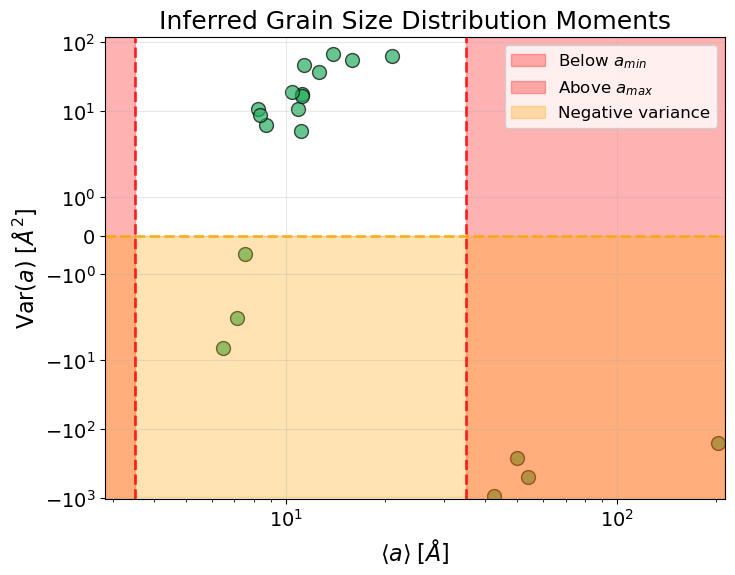

In [142]:
# Make the scatter plot of the first two moments
plt.figure(figsize=(8, 6))
plt.scatter(MC_catelogue_a_moments[:, 0], MC_catelogue_a_moments[:, 1], color='#27AE60', s=100, alpha=0.7, edgecolors='k')

# Add shading for invalid regions
ax = plt.gca()

# Convert a_min and a_max to Angstrom units (multiply by 1e8)
a_min_angstrom = a_min * 1e8
a_max_angstrom = a_max * 1e8

# Get current axis limits for shading
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Shade region below a_min (left side)
ax.axvspan(xlims[0], a_min_angstrom, alpha=0.3, color='red', label='Below $a_{min}$')

# Shade region above a_max (right side) 
ax.axvspan(a_max_angstrom, xlims[1], alpha=0.3, color='red', label='Above $a_{max}$')

# Shade region below y=0 (negative variance - unphysical)
ax.axhspan(ylims[0], 0, alpha=0.3, color='orange', label='Invalid variance')



# Add vertical lines to mark boundaries
ax.axvline(a_min_angstrom, color='red', linestyle='--', alpha=0.8, linewidth=2)
ax.axvline(a_max_angstrom, color='red', linestyle='--', alpha=0.8, linewidth=2)
ax.axhline(0, color='orange', linestyle='--', alpha=0.8, linewidth=2)

# set the x limits back to original
# ax.set_xlim(xlims[0], xlims[1])
# ax.set_ylim(ylims)

# Labels and formatting
plt.xlabel(r'$\langle a \rangle \; [\AA]$', fontsize=16)
plt.xscale('log')
plt.xlim(xlims[0], xlims[1])
plt.yscale('symlog')
plt.ylabel(r'Var$(a)$ [$\AA^2$]', fontsize=16)
plt.title('Inferred Grain Size Distribution Moments', fontsize=18)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='both', which='both', labelsize=14)

# Add legend
plt.legend(loc='upper right', fontsize=12)

plt.savefig("MC_inferred_size_distribution_moments.pdf", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_79439/886143129.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(xlims[0], xlims[1])


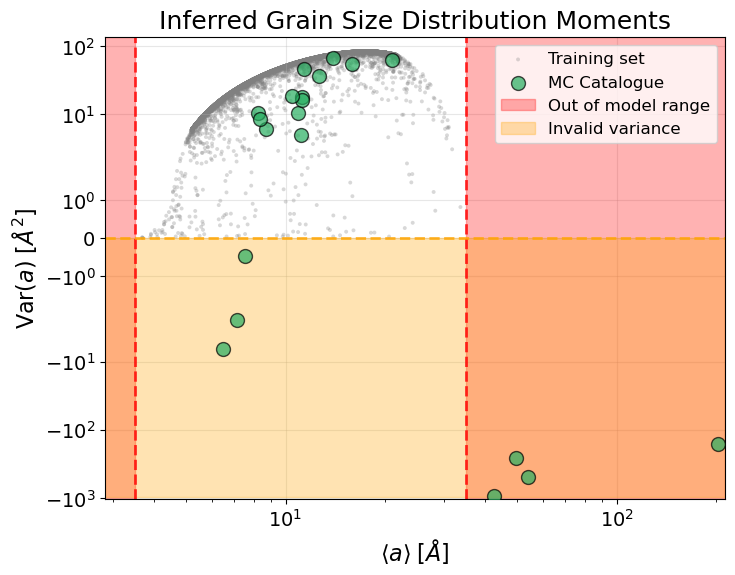

In [146]:
# Make the scatter plot of the first two moments
plt.figure(figsize=(8, 6))

# First, plot the training set as a light background
plt.scatter(a_moments_training_transformed[:, 0], a_moments_training_transformed[:, 1], 
           color='gray', s=8, alpha=0.3, edgecolors='none', 
           label='Training set', zorder=1)

# Then plot the main data points on top
plt.scatter(MC_catelogue_a_moments[:, 0], MC_catelogue_a_moments[:, 1], 
           color='#27AE60', s=100, alpha=0.7, edgecolors='k', 
           label='MC Catalogue', zorder=3)

# Add shading for invalid regions
ax = plt.gca()

# Convert a_min and a_max to Angstrom units (multiply by 1e8)
a_min_angstrom = a_min * 1e8
a_max_angstrom = a_max * 1e8

# Get current axis limits for shading
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Shade region below a_min (left side)
ax.axvspan(xlims[0], a_min_angstrom, alpha=0.3, color='red', 
          label='Out of model range', zorder=2)

# Shade region above a_max (right side) 
ax.axvspan(a_max_angstrom, xlims[1], alpha=0.3, color='red', 
        #   label='Above $a_{max}$', 
          zorder=2)

# Shade region below y=0 (negative variance - unphysical)
ax.axhspan(ylims[0], 0, alpha=0.3, color='orange', 
          label='Invalid variance', zorder=2)

# Add vertical lines to mark boundaries
ax.axvline(a_min_angstrom, color='red', linestyle='--', alpha=0.8, linewidth=2, zorder=2)
ax.axvline(a_max_angstrom, color='red', linestyle='--', alpha=0.8, linewidth=2, zorder=2)
ax.axhline(0, color='orange', linestyle='--', alpha=0.8, linewidth=2, zorder=2)

# Labels and formatting
plt.xlabel(r'$\langle a \rangle \; [\AA]$', fontsize=16)
plt.xscale('log')
plt.xlim(xlims[0], xlims[1])
plt.yscale('symlog')
plt.ylabel(r'Var$(a)$ [$\AA^2$]', fontsize=16)
plt.title('Inferred Grain Size Distribution Moments', fontsize=18)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='both', which='both', labelsize=14)

# Add legend with proper ordering
plt.legend(loc='upper right', fontsize=12)

plt.savefig("MC_inferred_size_distribution_moments_v2.pdf", dpi=300, bbox_inches='tight')
plt.show()